<p align="center">
  <img align="right" src="https://nilearn.github.io/dev-days-2020/assets/images/nilearn-logo.png" alt="image" width="250" />
</p>

<h1 align="center">MultiRat Sensory-Evoked analysis code</h1>

<p align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i>Marie E Galteau, 2023</i></p>

---

## Extract data from Region Of Interest (ROI)

The present jupyter notebook contains the code to extract the zscores, effect size, residuals and timesiries from predefined ROIs. These regions of interest are dependant on the stimulation location and are specified in the metadata file. 

Follow the code step-wise. 

In [1]:
# --- Imports ---
import os
import glob
import nilearn
import numpy as np
import pandas as pd
import nibabel as nib

from numpy import savetxt
from nilearn import plotting
from nilearn.maskers import NiftiMasker

**Select the hemodynamic response function!** 

To input the corresponding data. 

In [2]:
# --- Path to input / output data ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    spm
    glover
    Two_gammas
    Peak_span
"""
#hrf_function = 'glover'
#hrf_function = 'spm'
#hrf_function = 'Two_gammas'
hrf_function = 'Peak_span'

print('Fetch the data from the first level analysis that used:', hrf_function)

Fetch the data from the first level analysis that used: Peak_span


**Define input and output directories.**

In [3]:
# --- Init Variables ---
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

# --- Load templates and atlas --- 
template_folder = '/groupshare/traaffneu/preclinimg/templates/'
template_path = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
atlas_img = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_rs.nii')
atlas_labels = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt'
label_info = np.genfromtxt(atlas_labels, skip_header=10, delimiter='\t', dtype=str)
atlas_mask = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii')

# --- Output directories --- 

if hrf_function == 'glover':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
elif hrf_function == 'spm':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
elif hrf_function == 'Two_gammas':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/'
elif hrf_function == 'Peak_span':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/'
    
else:
    print('Define hrf_function.')

subdirectories = ['mask_ROIs']
zscores_dir = os.path.join(output_dir, 'mask_ROIs/z_scores/')
residuals_dir = os.path.join(output_dir, 'mask_ROIs/residuals/')
real_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/real_timeseries/')

for subdir in subdirectories:
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['z_scores', 'residuals', 'real_timeseries']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

**Let's extract the data!**
1. The 'for' loop iterates through scans. First step is to define the subject numver and load the corresponding scan.
2. Load the outputs of the 1st level analysis. 
3. Take the ROI(s) label in the metadata and find its equivalent index in the atlas. If there are two labels (right/left), they will be conjointly processed. 
4. Create a mask out of the selected ROI(s), fit it to the functional image and extract the signal from the ROI(s).
5. Save outputs.

>Note: extracting each type of signal can be very memory intensive and time consuming. 

In [5]:
# --- Extract data from ROI ---

for scan in range(179, len(df)) :         
     
    subj_num=str(df.iloc[scan]['rat.sub'])  #[:-2]
    ses=str(df.iloc[scan]['rat.ses'])
    print('index:', scan)
    print('subj:', subj_num)
    print('ses', ses)

    subj_img_glob = glob.glob(f'/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{subj_num}_ses-{ses}/bold_datasink/commonspace_bold/*/*/*.nii.gz')[0]
    subj_img = nib.load(subj_img_glob)
    
    # --- Load 1-level analysis outputs ---  
    zscores_file = nib.load(first_level_output +f'z_score/z_score_sub-0{subj_num}_ses-{ses}.nii.gz')
    residuals_file = nib.load(first_level_output +f'residuals/residuals_sub-0{subj_num}_ses-{ses}.nii.gz')
    beta_estimates_file = nib.load(first_level_output + f'beta_estimates/beta_sub-0{subj_num}_ses-{ses}.nii.gz')   

    # --- Define the ROI --- 
    labels_dict = {row[-1].strip('"'): int(row[0]) for row in label_info}       # Creates a dictionary with the atlas_label as the key and the label index as the value.
    labels = ['roi_right','roi_left']                                           # Create table with 2 columns, named as in the metadata
    label_indices = []                                                          # create an empty list 
    
    for label in labels:                                                        # Loop iterates through the elements in the labels list.
        atlas_label = df.iloc[scan][label]                                      # Extracts the value in the metadata dataframe, for 1 subject
        print(atlas_label)
        label_indices.append(labels_dict.get(atlas_label))                      # Appends the atlas_label index to the array to search for it later

    # --- Generate the ROI(s) masks --- 
    roi_mask = np.isin(nilearn.image.get_data(atlas_img), label_indices)        # To create the mask, select ROI(s) based on the index
    roi_mask = roi_mask.astype(bool)                                        

    roi_mask_img = nilearn.image.new_img_like(atlas_img, roi_mask)              # Create a mask image out of the roi selected
    masker = NiftiMasker(mask_img=roi_mask_img).fit(subj_img)                   # Fit the mask on the functional image
    masker_stand = NiftiMasker(mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)

    # --- Extract data from the ROI(s)
    residuals = masker.fit_transform(residuals_file)
    print("Done residuals")
    real_timeseries = masker.fit_transform(subj_img)
    print("Done real_timeseries")
    z_scores = masker.fit_transform(zscores_file)                             
    print("Done z_scores")

    # --- Save outputs --- 
    savetxt(residuals_dir+f'residuals_sub-0{subj_num}_ses-1.csv', residuals, delimiter=',') 
    savetxt(real_timeseries_dir+f'real_timeseries_sub-0{subj_num}_ses-1.csv', real_timeseries, delimiter=',') 
    savetxt(zscores_dir+f'zscores_sub-0{subj_num}_ses-1.csv', z_scores, delimiter=',')     
      
    print("Done Saving")

index: 179
subj: 202000
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 180
subj: 202001
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 181
subj: 202002
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 182
subj: 202003
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 183
subj: 202004
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 184
subj: 202005
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 185
subj: 202006
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 186
subj: 202007
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 187
subj: 202008
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 188
subj: 202009
ses 4
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 189
subj: 202100
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 190
subj: 202101
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 191
subj: 202102
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 192
subj: 202103
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 193
subj: 202104
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 194
subj: 202105
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 195
subj: 202106
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 196
subj: 202107
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 197
subj: 202108
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 198
subj: 202109
ses 4
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 199
subj: 202200
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 200
subj: 202201
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 201
subj: 202202
ses 1
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 202
subj: 202203
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 203
subj: 202204
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 204
subj: 202205
ses 2
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 205
subj: 202206
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 206
subj: 202207
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 207
subj: 202208
ses 3
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving
index: 208
subj: 202209
ses 4
Superficial Gray Layer of the Superior Colliculus-R
Superficial Gray Layer of the Superior Colliculus-L


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Done z_scores
Done Saving


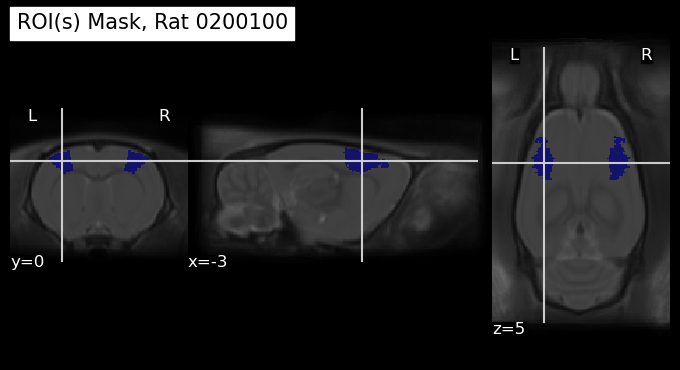

In [17]:
# --- Check the mask --- 
plotting.plot_roi(roi_mask_img, bg_img=template_path, title=f"ROI(s) Mask, Rat 0{subj_num}")